<a href="https://colab.research.google.com/github/ConSurv/HABP/blob/master/ConvDenoisingEncoder/DenoisingAutoEncoder_keras_Weizman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
print(GPUs)
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=59d6111123e5fb8f45e482cb113043c00f3f8683bb038fea496c3589ed6a5c51
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 26.3 GB  | Proc size: 158.5 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [0]:
! pip install keras_layer_normalization

  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.14.0-cp36-none-any.whl size=5268 sha256=cc7e437536e881f9ffc490f9a099b959f9a695d406a9209840aae77e3e9ba51c
  Stored in directory: /root/.cache/pip/wheels/54/80/22/a638a7d406fd155e507aa33d703e3fa2612b9eb7bb4f4fe667
Successfully built keras-layer-normalization


In [0]:
import keras
import cv2
import numpy as np
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D , MaxPooling2D,UpSampling2D
from keras.models import Sequential, load_model
from keras_layer_normalization import LayerNormalization
from os import listdir
from os.path import isfile, join, isdir
from PIL import Image
import numpy as np
import shelve
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [0]:
class Config:
    DATASET_PATH = "/content/drive/My Drive/FYP_MODEL/behavior_data".replace('\\', '/')
    BATCH_SIZE = 6
    EPOCHS = 10
    MODEL_PATH = "/content/drive/My Drive/FYP_MODEL/models/behav_model.hdf5".replace('\\', '/')
    noise_factor = 0.5


In [0]:
def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The desired distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 256 X 256
    sequence_size: int
        The size of the desired LSTM sequence
    Returns
    -------
    list
        A list of clips , 10 frames each
    """
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(clip)
                cnt = 0
    # print(len(clips))
    # print(np.array(clips).shape)
    return clips


In [0]:
def get_training_set():
    """
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    #####################################
    # cache = shelve.open(Config.CACHE_PATH)
    # return cache["datasetLSTM"]
    #####################################
    clips = []
    noise_clips = []
    labels = []
    # loop over the training folders (bend,jack....)
    for category in sorted(listdir(Config.DATASET_PATH)):
      # (/bend)
      if isdir(join(Config.DATASET_PATH, category)):
        label = category
        path = join(Config.DATASET_PATH,category)
        for subcat in sorted(listdir(path)):
            # sub-category= (daria_bend,denis_bend....)
            path1 = join(path,subcat)
            all_frames = []
            noise_all_frames = []
            for frame in sorted(listdir(path1)):
              if str(join(path1,frame))[-3:] == "jpg":
                imagepath = join(path1,frame)
                image = cv2.imread(imagepath)
                imageresize = cv2.resize(image, (256, 256), interpolation = cv2.INTER_AREA)
                img = cv2.cvtColor(imageresize, cv2.COLOR_BGR2GRAY)
                img1 = np.array(img, dtype=np.float32)/256.0
                noise_img = img1 + Config.noise_factor + np.random.rand(256,256)
                all_frames.append(img1)
                noise_all_frames.append(noise_img) 
                
            # get the 10-frames sequences from the list of images after applying data augmentation
            for stride in range(1, 2):
              frames = get_clips_by_stride(stride=1, frames_list=all_frames, sequence_size=15)
              noise_frames = get_clips_by_stride(stride=1, frames_list=noise_all_frames, sequence_size=15)
              clips.extend(frames)
              noise_clips.extend(noise_frames) 
              for i in range(0,len(frames)):
                labels.append(label)

    return clips,noise_clips,labels


In [0]:
def get_model(reload_model=True):
    """
    Parameters
    ----------
    reload_model : bool
        Load saved model or retrain it
    """
    if not reload_model:
        return load_model(Config.MODEL_PATH, custom_objects={'LayerNormalization': LayerNormalization})
   
    seq = Sequential()
    print("Model initialized")

    #################Encoder###############
    seq.add(
        TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 15, 256, 256, 1)))
    seq.add(LayerNormalization())

    seq.add(TimeDistributed(MaxPooling2D()))

    seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())

    seq.add(TimeDistributed(MaxPooling2D()))
     
    # # # # #
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # Code
    seq.add(ConvLSTM2D(16, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())

    ###########DECODER###############
    seq.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())

    seq.add(TimeDistributed(UpSampling2D()))

    seq.add(TimeDistributed(Conv2DTranspose(64, (11, 11), strides=4, padding="same")))
    seq.add(LayerNormalization())

    seq.add(TimeDistributed(UpSampling2D()))

    seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    print(seq.summary())
    seq.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-5, epsilon=1e-6))
    
    return seq


In [0]:
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
def evaluate(train_set, noise_train_set, validation_set, noise_validation_set):
    model = get_model(True)
    print("got model")

    # fit the model
    hist = model.fit(noise_train_set, train_set,
            batch_size=Config.BATCH_SIZE, epochs=Config.EPOCHS, shuffle=False,
            validation_data=(noise_validation_set, validation_set))
    model.save(Config.MODEL_PATH)
    return hist

In [0]:
# get training data
print("Fetching dataset.........")
train_set, noise_train_set, labels = get_training_set()
train_set = np.array(train_set)
noise_train_set = np.array(noise_train_set)
print("Completed Fetching!!!")
train_labels = np.zeros(len(labels))
# print(labels)
for i in range(len(labels)):
  if labels[i]=="bend":
    train_labels[i] = 0
  elif labels[i]=="jack":
    train_labels[i] = 1
  elif labels[i]=="jump":
    train_labels[i] = 2
  elif labels[i]=="pjump":
    train_labels[i] = 3
  elif labels[i]=="run":
    train_labels[i] = 4
  elif labels[i]=="side":
    train_labels[i] = 5
  elif labels[i]=="walk":
    train_labels[i] = 6
  elif labels[i]=="wave1":
    train_labels[i] = 7
  elif labels[i]=="wave2":
    train_labels[i] = 8
  else:
    train_labels[i] = 9
print("labels generated......")

# Save training images and labels in a numpy array
np.save('/content/drive/My Drive/FYP_MODEL/numpy_training_datasets/behavior/Behav_images.npy', train_set)
np.save('/content/drive/My Drive/FYP_MODEL/numpy_training_datasets/behavior/Behav_noise_images.npy', noise_train_set)
np.save('/content/drive/My Drive/FYP_MODEL/numpy_training_datasets/behavior/Behav_labels.npy', train_labels)

Fetching dataset.........
Completed Fetching!!!
labels generated......


In [0]:
print(noise_train_set.shape)
print(train_labels.shape)

(297, 15, 256, 256, 1)
(297,)


In [0]:
import numpy as np
# Load training images and labels that are stored in numpy array
train_set = np.load('/content/drive/My Drive/FYP_MODEL/numpy_training_datasets/behavior/Behav_images.npy')
noise_train_set = np.load('/content/drive/My Drive/FYP_MODEL/numpy_training_datasets/behavior/Behav_noise_images.npy')
train_labels =np.load('/content/drive/My Drive/FYP_MODEL/numpy_training_datasets/behavior/Behav_labels.npy')

print(train_set.shape)
print(noise_train_set.shape)
print(train_labels.shape)

FileNotFoundError: ignored

In [0]:
from sklearn.model_selection import train_test_split
# spliting testing dataset
train_set, test_set, noise_train_set, noise_test_set, train_labels, test_labels =  train_test_split(train_set, noise_train_set, train_labels, test_size=0.1, random_state=4)
train_set, validation_set, noise_train_set, noise_validation_set, train_labels, validation_labels =  train_test_split(train_set, noise_train_set, train_labels, test_size=0.1, random_state=4)


In [0]:
hist= evaluate(train_set, noise_train_set, validation_set, noise_validation_set)

Model initialized
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 64, 64, 128)   15616     
_________________________________________________________________
layer_normalization_1 (Layer (None, 15, 64, 64, 128)   256       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 32, 32, 128)   0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 16, 16, 64)    204864    
_________________________________________________________________
layer_normalization_2 (Layer (None, 15, 16, 16, 64)    128       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 8, 8, 64)      0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 

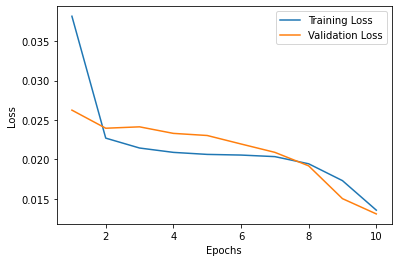

In [0]:
import matplotlib.pyplot as plt

loss_values = hist.history['loss']
loss_val = hist.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, loss_val, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
# modify model upto code layer
model = get_model(False)
modules = model.layers[:-9]
new_model = Sequential(modules)

# extract code features
train_features = new_model.predict(noise_train_set, batch_size = 4)
test_features = new_model.predict(noise_test_set, batch_size = 4)
validation_features = new_model.predict(noise_validation_set, batch_size = 4)

print(train_features.shape)
print(test_features.shape)
print(train_labels.shape)
print(test_labels.shape)
print(validation_features.shape)
print(validation_labels.shape)

(240, 15, 8, 8, 16)
(30, 15, 8, 8, 16)
(240,)
(30,)
(27, 15, 8, 8, 16)
(27,)


In [0]:
train_features = train_features.reshape(378,10*8*8*16)
test_features = test_features.reshape(47,10*8*8*16)
validation_features = validation_features.reshape(43,10*8*8*16)


print(train_features.shape)
print(test_features.shape)

np.save('/content/drive/My Drive/FYP_MODEL/numpy_training_datasets/Behav/train_features.npy', train_features)
np.save('/content/drive/My Drive/FYP_MODEL/numpy_training_datasets/Behav/test_features.npy', test_features)
np.save('/content/drive/My Drive/FYP_MODEL/numpy_training_datasets/Behav/validation_features.npy', validation_features)

np.save('/content/drive/My Drive/FYP_MODEL/numpy_training_datasets/Behav/train_labels.npy', train_labels)
np.save('/content/drive/My Drive/FYP_MODEL/numpy_training_datasets/Behav/test_labels.npy', test_labels)
np.save('/content/drive/My Drive/FYP_MODEL/numpy_training_datasets/Behav/validation_labels.npy', validation_labels)

(378, 10240)
(47, 10240)
